In [1]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"



In [3]:
root_folder = '/content/drive/MyDrive/dataset/train/L15-0331E-1257N_1327_3160_13/'

In [4]:
def preprocess_label_match_pix(label):
    image_labels = {}

    image_fname = label["properties"]["image_fname"]
    coords = label["geometry"]["coordinates"][0]
    label_id = label["properties"]["Id"]

    if image_fname not in image_labels:
        image_labels[image_fname] = {"boxes": [], "labels": []}

    xmin, ymin, xmax, ymax = (
        min([p[0] for p in coords]),
        min([p[1] for p in coords]),
        max([p[0] for p in coords]),
        max([p[1] for p in coords]),
    )
    image_labels[image_fname]["boxes"].append([xmin, ymin, xmax, ymax])
    image_labels[image_fname]["labels"].append(label_id)

    return image_labels


In [5]:

def load_data(root_folder):
    images = []
    labels = []
    for img_file in os.listdir(os.path.join(root_folder, 'images')):
        img_path = os.path.join(root_folder, 'images', img_file)
    for lab_file in os.listdir(os.path.join(root_folder, 'labels_match_pix')):
        label_path = os.path.join(root_folder, 'labels_match_pix')
        label_file = lab_file.split('.')[0] + '.geojson'
        label_path = os.path.join(root_folder, 'labels_match_pix', label_file)
        

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  
        with open(label_path, 'r',encoding='latin1') as f:
            label_data = json.load(f)

        labels.append(label_data['features'])
        images.append(img)
    return images, labels



In [6]:
class SatelliteDataset(Dataset):
    def __init__(self, images, label_data, transform=None):
        self.images = images
        self.label_data = label_data
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        labels = self.label_data[idx]
        
        processed_label_data = {"boxes": [], "labels": []}
        for label in labels:
            label_data = preprocess_label_match_pix(label)
            for key, value in label_data.items():
                # Use 'boxes' and 'labels' keys from label_data[key]
                processed_label_data["boxes"].extend(value["boxes"])
                processed_label_data["labels"].extend(value["labels"])

        # Apply the image transformations
        if self.transform:
            img = self.transform(img)

        return img, processed_label_data

In [7]:
def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    
    images = torch.stack(images, dim=0)
    
    return images, targets


In [8]:
images, labels = load_data(root_folder)



In [9]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

In [10]:
import torchvision.models.detection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # Create a Faster R-CNN model with a ResNet18-FPN backbone
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True, backbone_name='resnet18')

    # Replace the classifier with a new one that has the specified number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model


In [11]:
import torchvision.utils as utils
from torch.utils.data import DataLoader
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = len(train_labels[0]) + 1

model = get_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # resize all images to the same size
    transforms.RandomCrop((224, 224)),  # Randomly crop the images to 224x224 pixels
    transforms.ToTensor()
])
train_dataset = SatelliteDataset(train_images, train_labels, transform=train_transforms)

train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

In [12]:
def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do the average or sum
    Reduce the values in the dictionary from all processes so that process with rank
    0 has the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

def get_world_size():
    if not dist.is_available():
        return 1
    if not dist.is_initialized():
        return 1
    return dist.get_world_size()


In [13]:
from torch.cuda.amp import GradScaler, autocast

In [14]:
import math
import time
import torch
import torchvision
from collections import defaultdict, deque
import torch.distributed as dist
import statistics

class SmoothedValue:
    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def __str__(self):
        return self.fmt.format(
            median=statistics.median(self.deque),
            global_avg=self.total / max(1, self.count)
        )
class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def log_every(self, iterable, print_freq, header):
        i = 0
        size = len(iterable)
        start_time = time.time()
        end_time = start_time

        for obj in iterable:
            yield obj
            if i % print_freq == 0:
                elapsed_time = time.time() - end_time
                end_time = time.time()
                print('{}: {} [{}/{} ({:.0f}%)]\tElapsed: {:.2f}s\tETA: {:.2f}s'.format(
                    header, self, i, size, 100. * i / size, elapsed_time,
                    elapsed_time * (size - i) / max(1, i - size),
                ))
            i += 1

        total_time = time.time() - start_time
        print('{}: {} [{}/{} ({:.0f}%)]\tElapsed: {:.2f}s\tTotal: {:.2f}s\tSpeed: {:.2f} samples/s'.format(
            header, self, i, size, 100. * i / size, total_time,
            total_time, size / total_time,
        ))
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, accum_steps=10):
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1) 
    model.train()
    scaler = GradScaler()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    header = f"Epoch: [{epoch}]"

    for i, (images, targets) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        images = list(image.to(device) for image in images)
        targets = [
            {
                "boxes": torch.tensor(t["boxes"], dtype=torch.float32).to(device),
                "labels": torch.tensor(t["labels"], dtype=torch.int64).to(device)
            } for t in targets
        ]
        targets = correct_labels(targets, num_classes)

        # Forward pass with autocast
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization with gradient scaling
        scaler.scale(losses).backward()

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        if (i + 1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])





def evaluate(model, data_loader, device):
    model.eval()
    results = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = list(img.to(device) for img in images)
            torch.cuda.synchronize()
            outputs = model(images)
            results.append(outputs)

    return results


In [15]:
def correct_labels(targets, num_classes):
    for target in targets:
        target["labels"] = torch.clamp(target["labels"], min=0, max=num_classes - 1)
    return targets


In [19]:
def train_model(model, data_loader, optimizer, device, num_epochs):
   
    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # Update the learning rate
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        lr_scheduler.step()

# Train the model
num_epochs = 10
train_model(model, train_data_loader, optimizer, device, num_epochs)
print("Training completed.")


Epoch: [0]: lr: 0.0000 (0.0000)  loss: 99.0797 (99.0797)  loss_classifier: 7.6203 (7.6203)  loss_box_reg: 0.0044 (0.0044)  loss_objectness: 0.7001 (0.7001)  loss_rpn_box_reg: 90.7549 (90.7549) [0/20 (0%)]	Elapsed: 1.78s	ETA: 35.51s
Epoch: [0]: lr: 0.0000 (0.0000)  loss: 104.5506 (105.1395)  loss_classifier: 7.6207 (7.6204)  loss_box_reg: 0.0044 (0.0046)  loss_objectness: 0.6991 (0.6993)  loss_rpn_box_reg: 96.2266 (96.8152) [10/20 (50%)]	Elapsed: 9.76s	ETA: 97.62s
Epoch: [0]: lr: 0.0000 (0.0000)  loss: 106.3108 (107.7502)  loss_classifier: 7.6204 (7.6198)  loss_box_reg: 0.0042 (0.0042)  loss_objectness: 0.6989 (0.6990)  loss_rpn_box_reg: 97.9877 (99.4272) [20/20 (100%)]	Elapsed: 20.30s	Total: 20.30s	Speed: 0.99 samples/s
Epoch: [1]: lr: 0.0000 (0.0000)  loss: 120.4272 (120.4272)  loss_classifier: 7.6200 (7.6200)  loss_box_reg: 0.0038 (0.0038)  loss_objectness: 0.6985 (0.6985)  loss_rpn_box_reg: 112.1049 (112.1049) [0/20 (0%)]	Elapsed: 1.29s	ETA: 25.73s
Epoch: [1]: lr: 0.0000 (0.0000)  l

Prediction 0: [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]


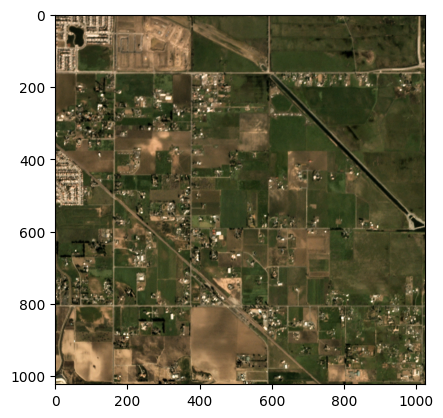

Prediction 1: [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]


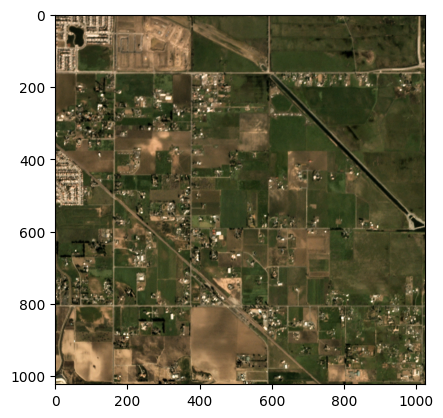

Prediction 2: [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]


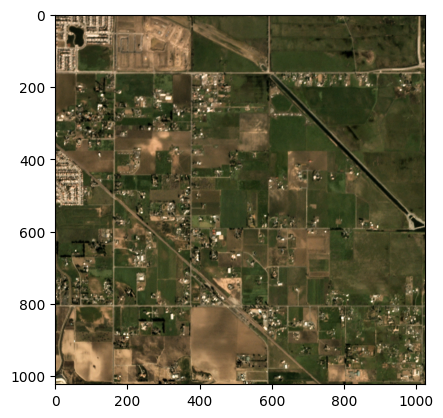

Prediction 3: [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]


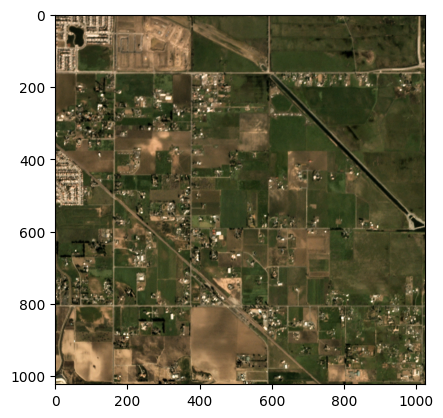

Prediction 4: [{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]


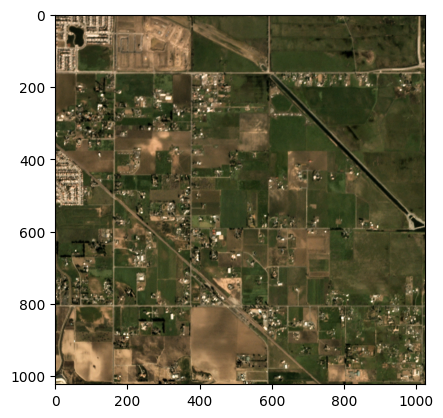

In [20]:

import matplotlib.patches as patches
def visualize_predictions(images, predictions, num_images_to_display=5):
    for i, prediction in enumerate(predictions[:num_images_to_display]):
        print(f"Prediction {i}: {prediction}")  # Debugging line
        image = images[i]
        fig, ax = plt.subplots(1)
        ax.imshow(image)

        if 'boxes' in prediction:
            boxes = prediction['boxes'].detach().numpy()
            labels = prediction['labels'].detach().numpy()
            scores = prediction['scores'].detach().numpy()

            for box, label, score in zip(boxes, labels, scores):
                if score > 0.5:
                    x1, y1, x2, y2 = box
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x1, y1, f"{label}: {score:.2f}", fontsize=8, color='white', bbox=dict(facecolor='red', alpha=0.5))

        plt.show()



# Evaluate the model
test_transforms = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
test_dataset = SatelliteDataset(test_images, test_labels, transform=test_transforms)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)
model.eval()
predictions = evaluate(model, test_data_loader, device=device)

# Visualize results
visualize_predictions(test_images, predictions)
